**project** : Ali Jokar 402202373

# import libraries and load data

In [3]:
# Import libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# drive mount

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Paths to directories

train_directory = "/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/train3"
validation_directory = "/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/val3"
test_directory = "/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/test3"


In [ ]:
def count_dataset(directory):
    total_samples = 0
    class_counts = {}
    for class_name in os.listdir(directory):
        class_directory = os.path.join(directory, class_name)
        if os.path.isdir(class_directory):
            class_count = len(os.listdir(class_directory))
            total_samples += class_count
            class_counts[class_name] = class_count

    return total_samples, class_counts


# Count samples in each dataset
train_total, train_class_counts = count_dataset(train_directory)
validation_total, validation_class_counts = count_dataset(validation_directory)
test_total, test_class_counts = count_dataset(test_directory)

print("Train dataset:")
print("Total samples:", train_total)
print("Class counts:", train_class_counts)
print()

print("Validation dataset:")
print("Total samples:", validation_total)
print("Class counts:", validation_class_counts)
print()

print("Test dataset:")
print("Total samples:", test_total)
print("Class counts:", test_class_counts)

Train dataset:
Total samples: 5788
Class counts: {'1': 3502, '0': 2286}

Validation dataset:
Total samples: 826
Class counts: {'1': 498, '0': 328}

Test dataset:
Total samples: 1706
Class counts: {'1': 1047, '0': 659}


In [ ]:
def count_samples_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_directory = os.path.join(directory, class_name)
        if os.path.isdir(class_directory):
            class_counts[class_name] = len(os.listdir(class_directory))
    return class_counts


In [ ]:
def plot_dataset_distribution(directory, title):
    class_counts = count_samples_per_class(directory)
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(15, 6))
    plt.bar(classes, counts, color='red')
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

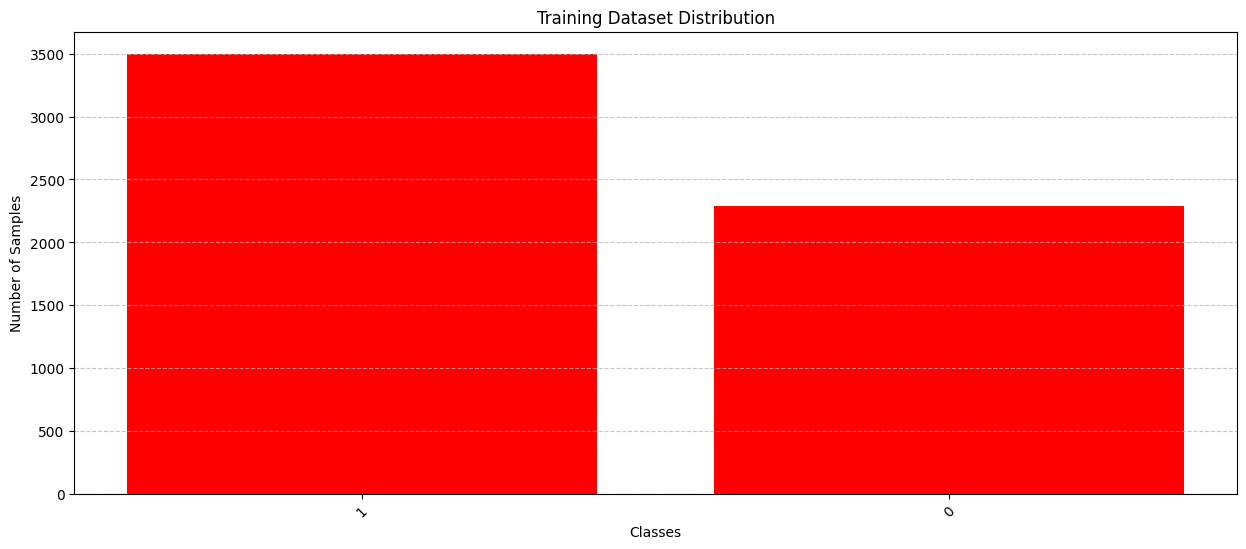

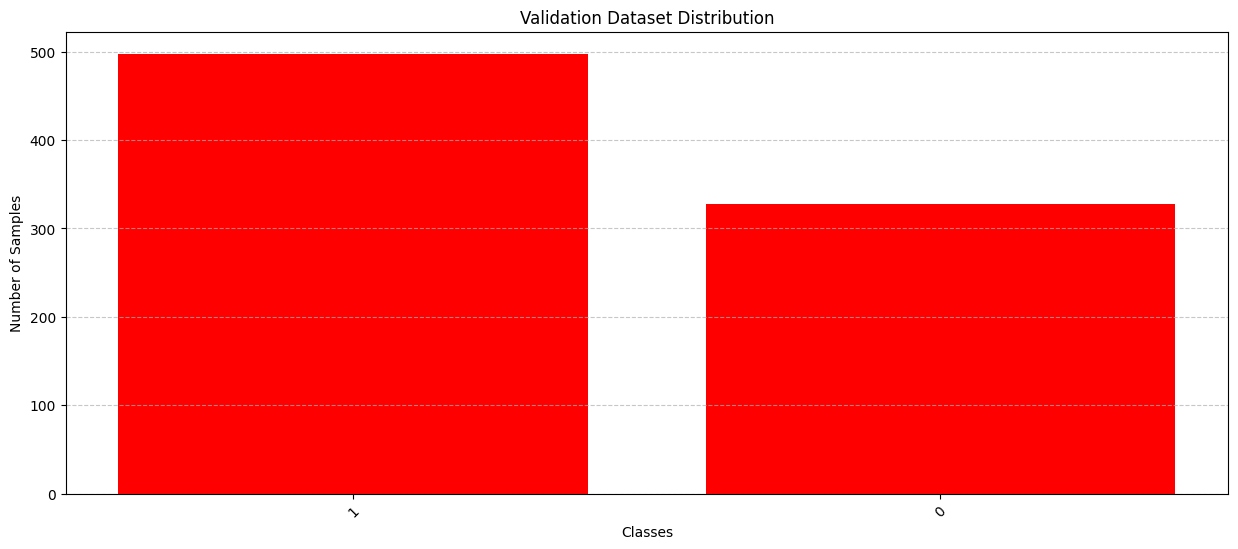

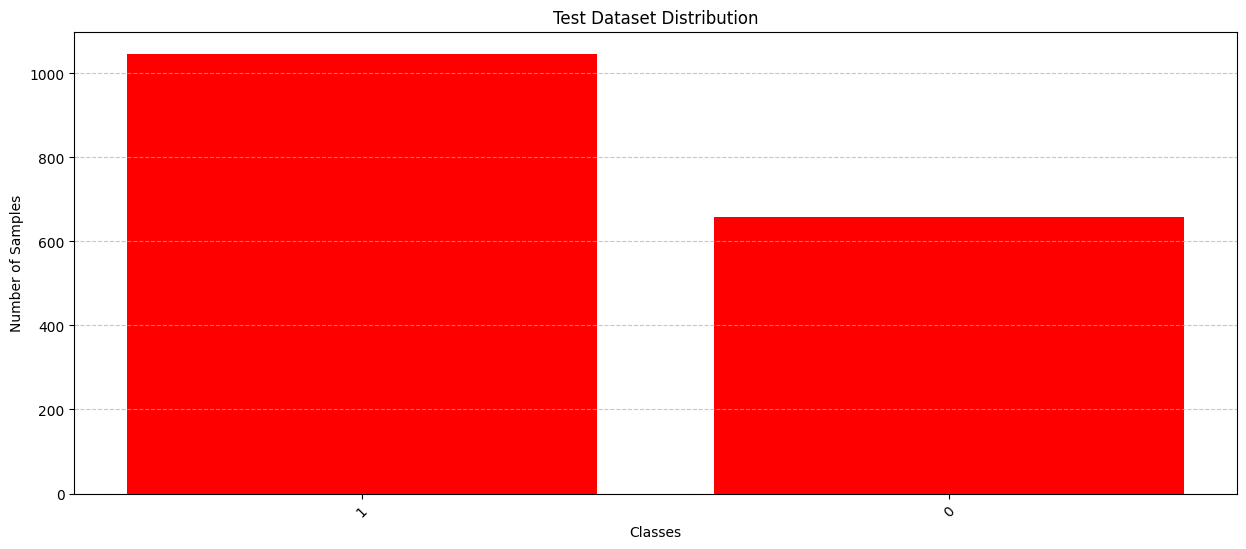

In [ ]:
# Plot distribution of samples in training dataset
plot_dataset_distribution(train_directory, title='Training Dataset Distribution')

# Plot distribution of samples in validation dataset
plot_dataset_distribution(validation_directory, title='Validation Dataset Distribution')

# Plot distribution of samples in test dataset
plot_dataset_distribution(test_directory, title='Test Dataset Distribution')


In [ ]:
# Function to load and preprocess images
def load_images(folder_path, img_size):
    images = []
    labels = []

    for folder_name in os.listdir(folder_path):
        folder = os.path.join(folder_path, folder_name)
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(folder_name)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [ ]:
# Function to preprocess data
def preprocess_data(images, labels):
    # Convert labels to one-hot encoding
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    num_classes = len(label_encoder.classes_)
    labels_onehot = tf.keras.utils.to_categorical(labels_encoded, num_classes=num_classes)

    # Normalize pixel values
    images = images.astype('float32') / 255.0

    return images, labels_onehot

In [ ]:
# Function to visualize four images from each class
def visualize_dataset(images, labels):
    # Get unique class labels
    classes = np.unique(labels)

    # Create a figure
    fig, axes = plt.subplots(len(classes), 4, figsize=(16, 4 * len(classes)))

    # Loop through each class
    for i, cls in enumerate(classes):
        # Get indices of images belonging to the current class
        indices = np.where(labels == cls)[0]
        # Randomly select four indices
        sample_indices = random.sample(list(indices), min(4, len(indices)))

        # Loop through each image index
        for j, idx in enumerate(sample_indices):
            # Display the image
            axes[i, j].imshow(images[idx])
            axes[i, j].set_title(cls)
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Set paths to image folders
folder_path = "/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/train3"
img_size = 224

# Load images and labels of train dataset
images, labels = load_images(folder_path, img_size)

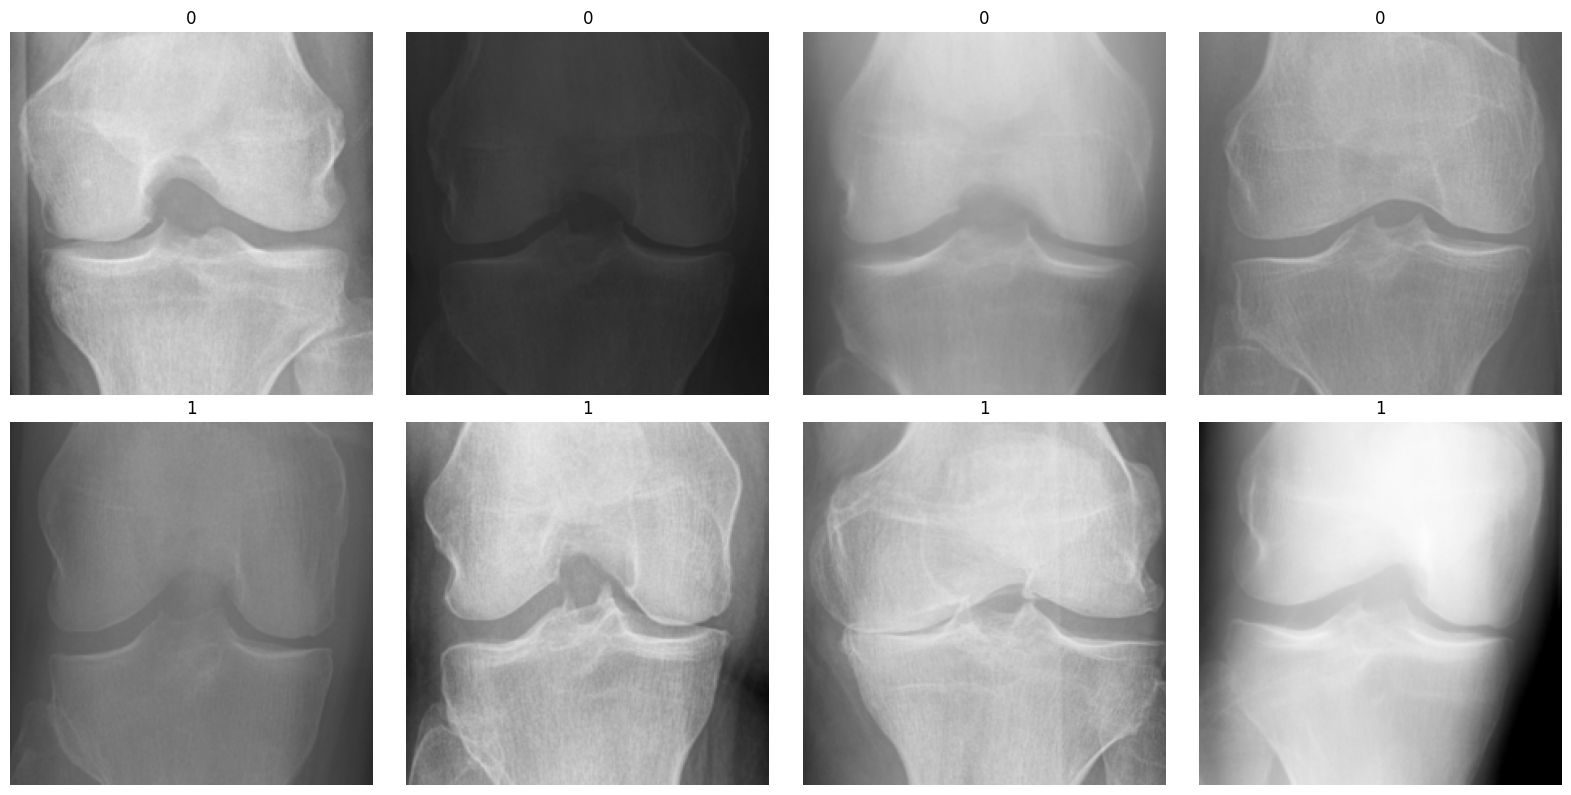

In [ ]:
# Visualize four images from each class
visualize_dataset(images, labels)

In [ ]:
# Define constants
image_size = (224, 224)
batch_size = 32
num_classes = 2

# Create data generators for training, validation, and testing
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Convert true labels to class labels
true_labels = test_generator.classes

Found 5788 images belonging to 2 classes.
Found 826 images belonging to 2 classes.
Found 1706 images belonging to 2 classes.


In [ ]:
def load_and_preprocess_images(folder_path, img_size=(224, 224)):
    images = []
    labels = []
    label_to_index = {}  # Dictionary to map class names to numerical indices

    for i, class_name in enumerate(os.listdir(folder_path)):
        class_folder_path = os.path.join(folder_path, class_name)
        label_to_index[class_name] = i

        for filename in os.listdir(class_folder_path):
            image_path = os.path.join(class_folder_path, filename)
            image = cv2.imread(image_path)  # Load image in RGB format
            # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert BGR to RGB

            # Resize image to 224*224
            image = cv2.resize(image, img_size)

            # Preprocess image (normalize pixel values)
            image = preprocess_input(image)

            images.append(image)
            labels.append(class_name)  # Append class name

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Encode labels to numerical values
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    # Convert numerical labels to one-hot encoding
    one_hot_labels = to_categorical(encoded_labels)

    return images, one_hot_labels, label_to_index

# Load and preprocess train, validation, and test data
X_train, y_train, label_to_index_train = load_and_preprocess_images(train_directory)
X_val, y_val, label_to_index_val = load_and_preprocess_images(validation_directory)
X_test, y_test, label_to_index_test = load_and_preprocess_images(test_directory)

# Print shapes of loaded data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Print label-to-index mappings
print("Label to index (Train):", label_to_index_train)
print("Label to index (Validation):", label_to_index_val)
print("Label to index (Test):", label_to_index_test)

X_train shape: (5788, 224, 224, 3)
y_train shape: (5788, 2)
X_val shape: (826, 224, 224, 3)
y_val shape: (826, 2)
X_test shape: (1706, 224, 224, 3)
y_test shape: (1706, 2)
Label to index (Train): {'1': 0, '0': 1}
Label to index (Validation): {'1': 0, '0': 1}
Label to index (Test): {'1': 0, '0': 1}


# Section A

In [ ]:
# Define and compile the CNN model
cnn_model = tf.keras.Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    GlobalAveragePooling2D(),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 128)     5

In [ ]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

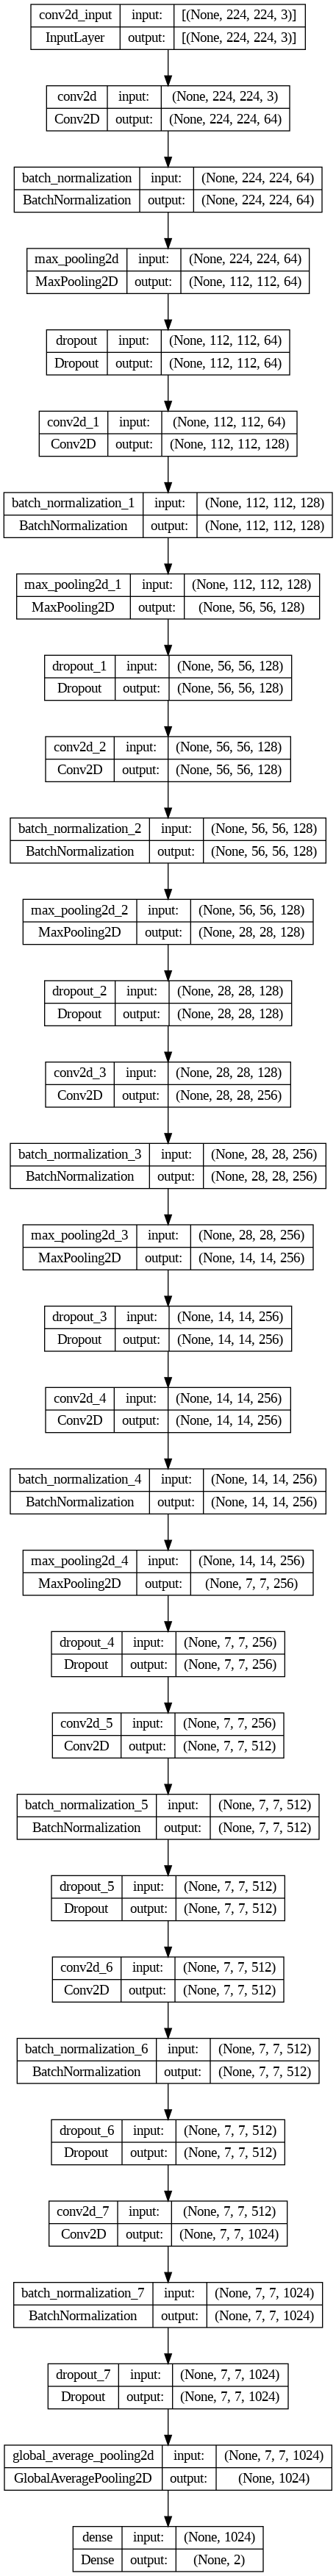

In [ ]:
# visualize the model

tf.keras.utils.plot_model(cnn_model, show_shapes=True)


In [ ]:
# Train the CNN model
epochs = 10
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/kneeXray_cnn_model_p3.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

cnn_history = cnn_model.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[checkpoint])


Epoch 1/10
181/181 [==============================] - ETA: 0s - loss: 10.3346 - accuracy: 0.5619
Epoch 1: val_accuracy improved from -inf to 0.60291, saving model to /content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/kneeXray_cnn_model_p3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


181/181 [==============================] - 76s 331ms/step - loss: 10.3346 - accuracy: 0.5619 - val_loss: 2.9295 - val_accuracy: 0.6029
Epoch 2/10
181/181 [==============================] - ETA: 0s - loss: 1.7554 - accuracy: 0.5720
Epoch 2: val_accuracy did not improve from 0.60291
181/181 [==============================] - 53s 293ms/step - loss: 1.7554 - accuracy: 0.5720 - val_loss: 1.1526 - val_accuracy: 0.6029
Epoch 3/10
181/181 [==============================] - ETA: 0s - loss: 1.1152 - accuracy: 0.5822
Epoch 3: val_accuracy did not improve from 0.60291
181/181 [==============================] - 53s 290ms/step - loss: 1.1152 - accuracy: 0.5822 - val_loss: 1.6834 - val_accuracy: 0.3971
Epoch 4/10
181/181 [==============================] - ETA: 0s - loss: 1.0578 - accuracy: 0.5767
Epoch 4: val_accuracy did not improve from 0.60291
181/181 [==============================] - 51s 280ms/step - loss: 1.0578 - accuracy: 0.5767 - val_loss: 1.1759 - val_accuracy: 0.5678
Epoch 5/10
181/181 [==

In [ ]:
# load model
cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/kneeXray_cnn_model_p3.h5')

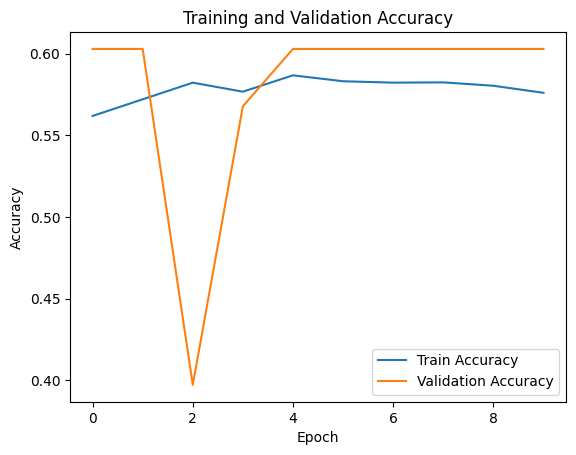

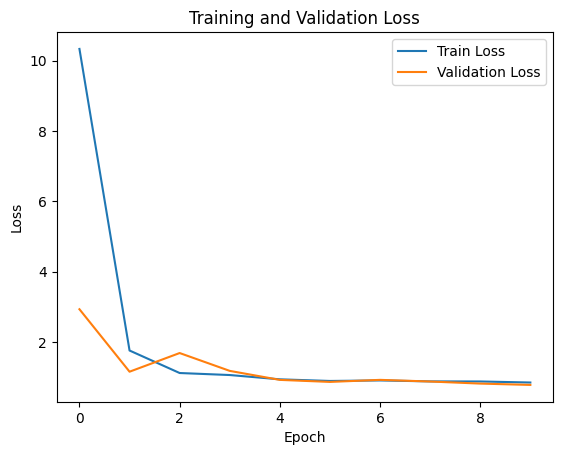

In [ ]:
# plot train and val accuracy and loss

# Plot the training and validation accuracy
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Get predictions on the test data
y_pred = cnn_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to numerical labels
# y_test_numerical = np.argmax(y_test, axis=1)
y_true = test_generator.classes

# Generate classification report
report = classification_report(y_true, y_pred_classes)

print("Classification Report:")
print(report)

# Calculate and print accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Test accuracy: {accuracy * 100:.2f}%')

54/54 [==============================] - 10s 182ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       659
           1       0.61      1.00      0.76      1047

    accuracy                           0.61      1706
   macro avg       0.31      0.50      0.38      1706
weighted avg       0.38      0.61      0.47      1706

Test accuracy: 61.37%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


54/54 [==============================] - 10s 176ms/step


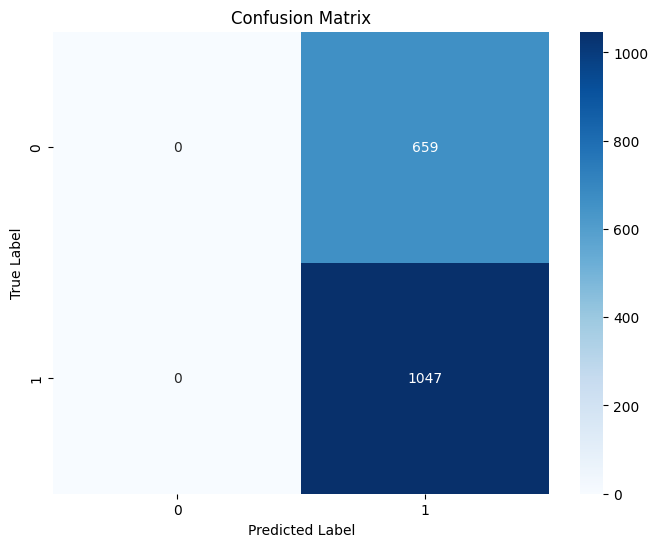

In [ ]:
#  plot confusion matrix

# Get predictions on the test data
y_pred = cnn_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to numerical labels

y_true = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

54/54 [==============================] - 8s 156ms/step


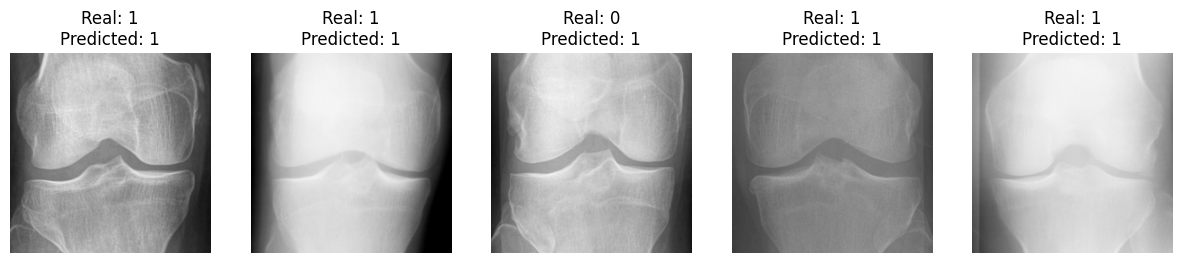

In [ ]:
# Get predictions on the test data
y_pred = cnn_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Retrieve true labels
y_true = test_generator.classes

# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Select a few random examples to visualize
num_examples = 5
random_indices = np.random.choice(len(test_generator.filenames), num_examples, replace=False)

# Get the images and corresponding labels from the test generator
images, _ = test_generator.next()
while len(images) < len(test_generator.filenames):
    next_images, _ = test_generator.next()
    images = np.concatenate((images, next_images))

# Plot the images and their corresponding predictions
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_examples, i + 1)

    # Clip the data to ensure it falls within the valid range
    image_data = np.clip(images[idx], 0, 1) if np.issubdtype(images[idx].dtype, np.floating) else np.clip(images[idx], 0, 255)

    plt.imshow(image_data)
    plt.title(f"Real: {class_labels[y_true[idx]]}\nPredicted: {class_labels[y_pred_classes[idx]]}")
    plt.axis('off')
plt.show()


# Section B (vision transformer)

In [ ]:
!pip install -q tensorflow_addons

In [ ]:
!pip install vit-keras

In [ ]:
from vit_keras import vit

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Load pre-trained ViT model (ViT-B/16 configuration)
base_model = vit.vit_b16(
    image_size=224,
    activation='softmax',
    pretrained=True,
    include_top=False,  # Exclude the classification head
    pretrained_top=False
)

# Freeze the base ViT model layers
base_model.trainable = True

# Add classification head on top of the base model
x = tf.keras.layers.Flatten()(base_model.output)
x = Dropout(0.5)(x)  # Add dropout for regularization
output = Dense(2, activation='softmax')(x)  # 5 output classes
vit_model = Model(base_model.input, output)

# Compile the model
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

vit_model.summary()

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input  (None, 197, 768)          151296    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 197, 768),        7087872   
  (TransformerBlock)          (None, 12, None, None)         

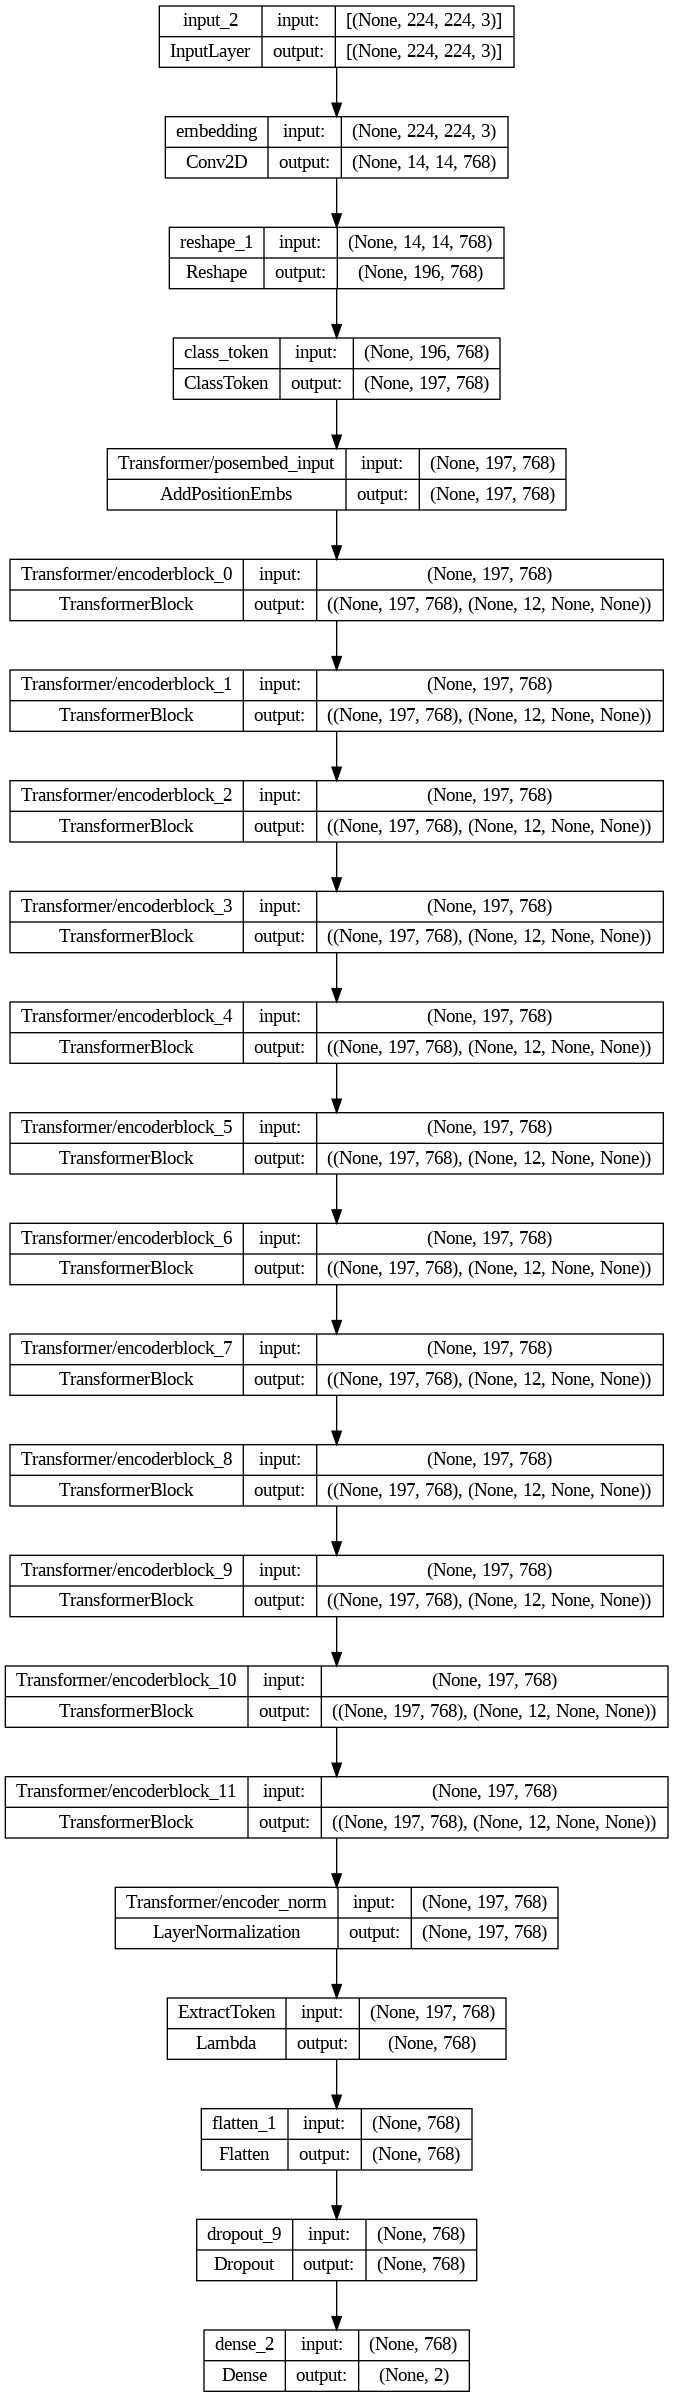

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(vit_model, show_shapes=True)

In [ ]:
# Train the vit model
epochs = 10
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/kneeXray_vit_model_p3.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

vit_history = vit_model.fit(train_generator, epochs=epochs, validation_data=validation_generator,callbacks=[checkpoint])


Epoch 1/10
181/181 [==============================] - ETA: 0s - loss: 0.7766 - accuracy: 0.5731
Epoch 1: val_accuracy improved from -inf to 0.67070, saving model to /content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/kneeXray_vit_model_p3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


181/181 [==============================] - 333s 2s/step - loss: 0.7766 - accuracy: 0.5731 - val_loss: 0.5939 - val_accuracy: 0.6707
Epoch 2/10
181/181 [==============================] - ETA: 0s - loss: 0.5621 - accuracy: 0.6963
Epoch 2: val_accuracy improved from 0.67070 to 0.75666, saving model to /content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/kneeXray_vit_model_p3.h5
181/181 [==============================] - 455s 3s/step - loss: 0.5621 - accuracy: 0.6963 - val_loss: 0.4944 - val_accuracy: 0.7567
Epoch 3/10
181/181 [==============================] - ETA: 0s - loss: 0.4902 - accuracy: 0.7467
Epoch 3: val_accuracy did not improve from 0.75666
181/181 [==============================] - 236s 1s/step - loss: 0.4902 - accuracy: 0.7467 - val_loss: 0.4880 - val_accuracy: 0.7554
Epoch 4/10
181/181 [==============================] - ETA: 0s - loss: 0.4480 - accuracy: 0.7752
Epoch 4: val_accuracy did not improve from 0.75666
181/181 [==============================] - 245s 1s/step - los

In [ ]:
# load model
vit_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/kneeXray_vit_model_p3.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


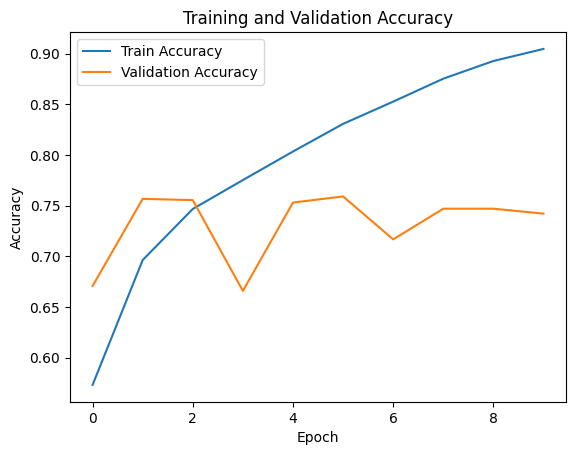

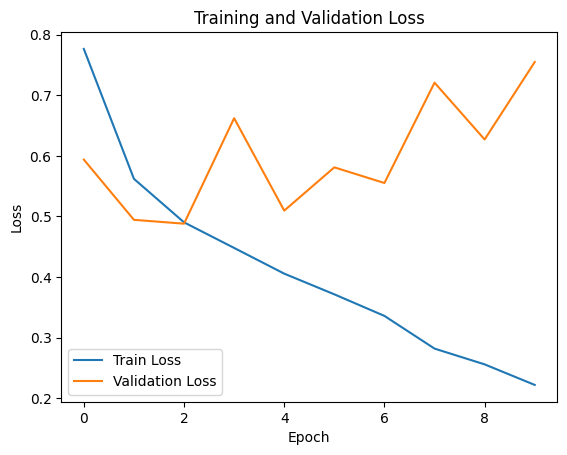

In [ ]:
# plot train and val accuracy and loss

# Plot the training and validation accuracy
plt.plot(vit_history.history['accuracy'], label='Train Accuracy')
plt.plot(vit_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(vit_history.history['loss'], label='Train Loss')
plt.plot(vit_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Get predictions on the test data
y_pred_vit = vit_model.predict(test_generator)
y_pred_classes_vit = np.argmax(y_pred_vit, axis=1)

# Convert one-hot encoded labels back to numerical labels
y_true = test_generator.classes

# Generate classification report
report = classification_report(y_true, y_pred_classes_vit)

print("Classification Report:")
print(report)

# Calculate and print accuracy
accuracy = accuracy_score(y_true, y_pred_classes_vit)
print(f'Test accuracy: {accuracy * 100:.2f}%')

54/54 [==============================] - 26s 409ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.82      0.73       659
           1       0.87      0.73      0.79      1047

    accuracy                           0.77      1706
   macro avg       0.76      0.78      0.76      1706
weighted avg       0.79      0.77      0.77      1706

Test accuracy: 76.67%


54/54 [==============================] - 22s 408ms/step


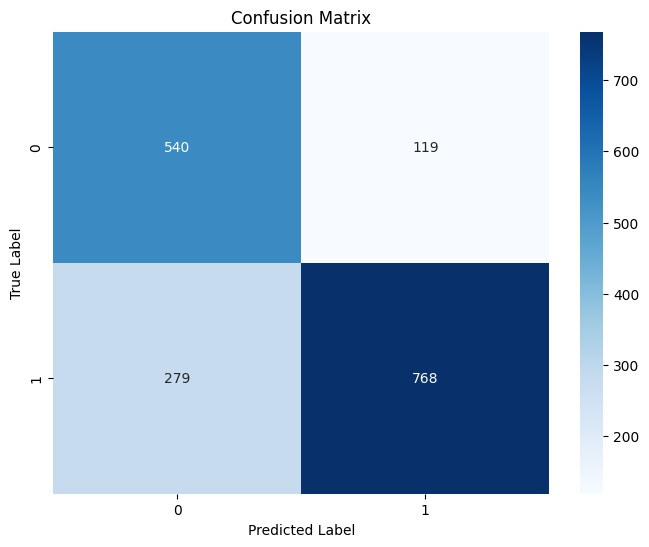

In [ ]:
#  plot confusion matrix

# Get predictions on the test data
y_pred_vit = vit_model.predict(test_generator)
y_pred_classes_vit = np.argmax(y_pred_vit, axis=1)

# Convert one-hot encoded labels back to numerical labels
y_true = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes_vit)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


54/54 [==============================] - 28s 392ms/step


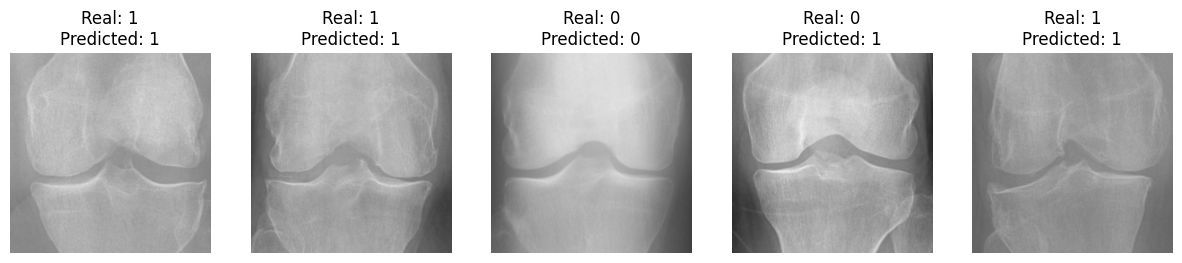

In [ ]:
# Get predictions on the test data
y_pred_vit = vit_model.predict(test_generator)
y_pred_classes_vit = np.argmax(y_pred_vit, axis=1)

# Retrieve true labels
y_true = test_generator.classes

# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Select a few random examples to visualize
num_examples = 5
random_indices = np.random.choice(len(test_generator.filenames), num_examples, replace=False)

# Get the images and corresponding labels from the test generator
images, _ = test_generator.next()
while len(images) < len(test_generator.filenames):
    next_images, _ = test_generator.next()
    images = np.concatenate((images, next_images))

# Plot the images and their corresponding predictions
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_examples, i + 1)

    # Clip the data to ensure it falls within the valid range
    image_data = np.clip(images[idx], 0, 1) if np.issubdtype(images[idx].dtype, np.floating) else np.clip(images[idx], 0, 255)

    plt.imshow(image_data)
    plt.title(f"Real: {class_labels[y_true[idx]]}\nPredicted: {class_labels[y_pred_classes_vit[idx]]}")
    plt.axis('off')
plt.show()


# Section D (transfer learning)


In [ ]:
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
#  load ResNet50 with ImageNet
resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# create new resnet_model
resnet_model = tf.keras.models.Sequential()
resnet_model.add(resnet_base_model)
resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(2, activation='softmax'))  # classifier layer

# freeze layers of base resnet_model
for layer in resnet_base_model.layers:
    layer.trainable = False

#  resnet_model compile
resnet_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])

# callback for save the best resnet_model
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/kneeXray_resnet_model_p3.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

resnet_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 2)                 200706    
                                                                 
Total params: 23788418 (90.75 MB)
Trainable params: 200706 (784.01 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


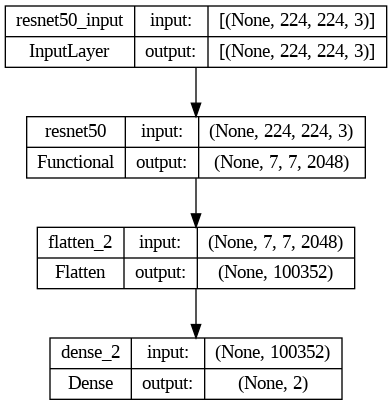

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(resnet_model, show_shapes=True)

In [ ]:
# train resnet_model
epochs = 5

resnet_history = resnet_model.fit(train_generator,
                                  epochs=epochs,
                                  validation_data=validation_generator,
                                  callbacks=[checkpoint]
)

Epoch 1/5
181/181 [==============================] - ETA: 0s - loss: 0.7038 - accuracy: 0.5672
Epoch 1: val_accuracy did not improve from 0.60896
181/181 [==============================] - 42s 223ms/step - loss: 0.7038 - accuracy: 0.5672 - val_loss: 0.7245 - val_accuracy: 0.4104
Epoch 2/5
181/181 [==============================] - ETA: 0s - loss: 0.6864 - accuracy: 0.5777
Epoch 2: val_accuracy did not improve from 0.60896
181/181 [==============================] - 38s 209ms/step - loss: 0.6864 - accuracy: 0.5777 - val_loss: 0.6586 - val_accuracy: 0.6005
Epoch 3/5
181/181 [==============================] - ETA: 0s - loss: 0.6719 - accuracy: 0.5962
Epoch 3: val_accuracy did not improve from 0.60896
181/181 [==============================] - 37s 206ms/step - loss: 0.6719 - accuracy: 0.5962 - val_loss: 0.6644 - val_accuracy: 0.6017
Epoch 4/5
181/181 [==============================] - ETA: 0s - loss: 0.6950 - accuracy: 0.5736
Epoch 4: val_accuracy did not improve from 0.60896
181/181 [=====

In [ ]:
# load model
resnet_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/kneeXray_resnet_model_p3.h5')

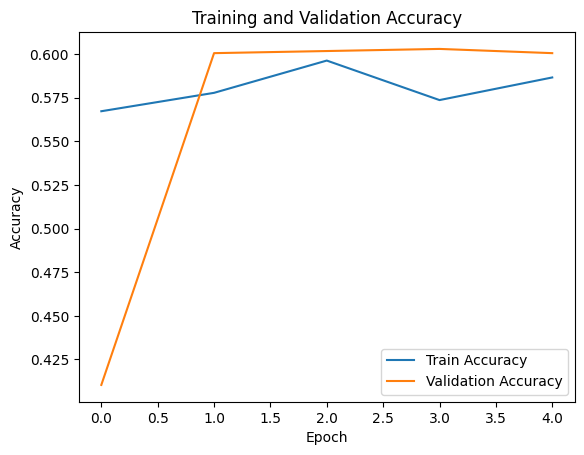

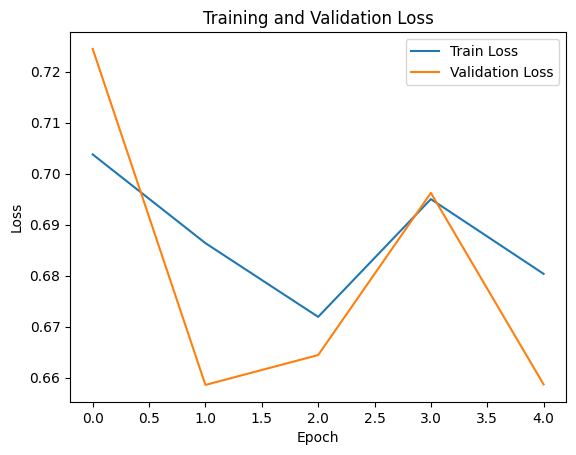

In [ ]:
# plot train and val accuracy and loss

# Plot the training and validation accuracy
plt.plot(resnet_history.history['accuracy'], label='Train Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(resnet_history.history['loss'], label='Train Loss')
plt.plot(resnet_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Get predictions on the test data
y_pred_resnet = resnet_model.predict(test_generator)
y_pred_classes_resnet = np.argmax(y_pred_resnet, axis=1)

# Convert one-hot encoded labels back to numerical labels
y_true = test_generator.classes

# Generate classification report
report = classification_report(y_true, y_pred_classes_resnet)

print("Classification Report:")
print(report)

# Calculate and print accuracy
accuracy = accuracy_score(y_true, y_pred_classes_resnet)
print(f'Test accuracy: {accuracy * 100:.2f}%')

54/54 [==============================] - 12s 189ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.01      0.02       659
           1       0.61      0.99      0.76      1047

    accuracy                           0.61      1706
   macro avg       0.54      0.50      0.39      1706
weighted avg       0.56      0.61      0.47      1706

Test accuracy: 61.31%


54/54 [==============================] - 9s 173ms/step


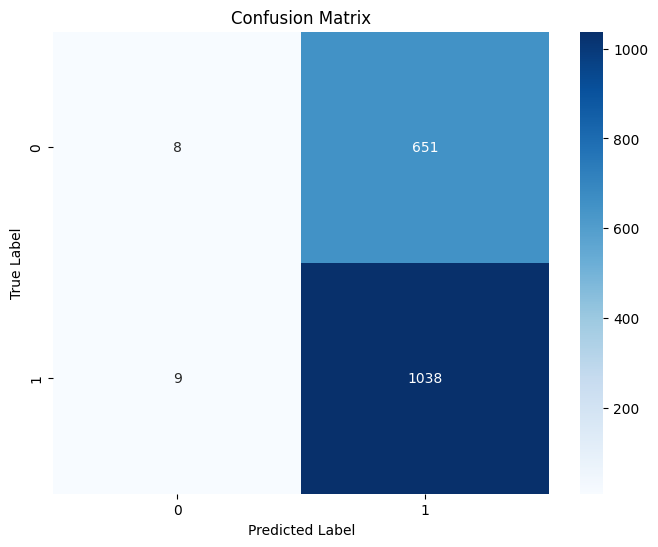

In [ ]:
#  plot confusion matrix

# Get predictions on the test data
y_pred_resnet = resnet_model.predict(test_generator)
y_pred_classes_resnet = np.argmax(y_pred_resnet, axis=1)

# Convert one-hot encoded labels back to numerical labels

y_true = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes_resnet)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


54/54 [==============================] - 10s 181ms/step


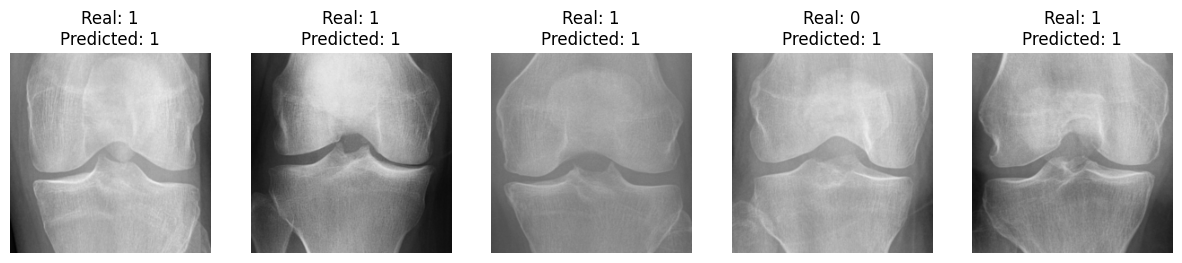

In [ ]:
# Get predictions on the test data
y_pred_resnet = resnet_model.predict(test_generator)
y_pred_classes_resnet = np.argmax(y_pred_resnet, axis=1)

# Retrieve true labels
y_true = test_generator.classes

# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Select a few random examples to visualize
num_examples = 5
random_indices = np.random.choice(len(test_generator.filenames), num_examples, replace=False)

# Get the images and corresponding labels from the test generator
images, _ = test_generator.next()
while len(images) < len(test_generator.filenames):
    next_images, _ = test_generator.next()
    images = np.concatenate((images, next_images))

# Plot the images and their corresponding predictions
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_examples, i + 1)

    # Clip the data to ensure it falls within the valid range
    image_data = np.clip(images[idx], 0, 1) if np.issubdtype(images[idx].dtype, np.floating) else np.clip(images[idx], 0, 255)

    plt.imshow(image_data)
    plt.title(f"Real: {class_labels[y_true[idx]]}\nPredicted: {class_labels[y_pred_classes_resnet[idx]]}")
    plt.axis('off')
plt.show()


# Section E (fine tune all parameters)


In [ ]:
#  load ResNet50 with ImageNet
resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# create new resnet_model_2
resnet_model_2 = tf.keras.models.Sequential()
resnet_model_2.add(resnet_base_model)
resnet_model_2.add(tf.keras.layers.Flatten())
resnet_model_2.add(tf.keras.layers.Dense(2, activation='softmax'))  # classifier layer

# freeze layers of base resnet_model_2
for layer in resnet_base_model.layers:
    layer.trainable = True

#  resnet_model_2 compile
resnet_model_2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])

# callback for save the best resnet_model_2
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/kneeXray_resnet_model_2_p3.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

resnet_model_2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_3 (Dense)             (None, 2)                 200706    
                                                                 
Total params: 23788418 (90.75 MB)
Trainable params: 23735298 (90.54 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


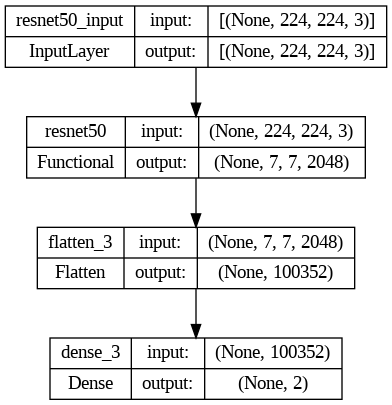

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(resnet_model_2, show_shapes=True)

In [ ]:
# train resnet_model
epochs = 15

resnet_history_2 = resnet_model_2.fit(train_generator,
                                  epochs=epochs,
                                  validation_data=validation_generator,
                                  callbacks=[checkpoint]
)

Epoch 1/15
181/181 [==============================] - ETA: 0s - loss: 1.2529 - accuracy: 0.6522
Epoch 1: val_accuracy improved from -inf to 0.59927, saving model to /content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/kneeXray_resnet_model_2_p3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


181/181 [==============================] - 109s 397ms/step - loss: 1.2529 - accuracy: 0.6522 - val_loss: 0.6776 - val_accuracy: 0.5993
Epoch 2/15
181/181 [==============================] - ETA: 0s - loss: 0.5266 - accuracy: 0.7885
Epoch 2: val_accuracy did not improve from 0.59927
181/181 [==============================] - 67s 367ms/step - loss: 0.5266 - accuracy: 0.7885 - val_loss: 0.8830 - val_accuracy: 0.3971
Epoch 3/15
181/181 [==============================] - ETA: 0s - loss: 0.2240 - accuracy: 0.9122
Epoch 3: val_accuracy did not improve from 0.59927
181/181 [==============================] - 66s 361ms/step - loss: 0.2240 - accuracy: 0.9122 - val_loss: 0.6797 - val_accuracy: 0.5811
Epoch 4/15
181/181 [==============================] - ETA: 0s - loss: 0.1368 - accuracy: 0.9496
Epoch 4: val_accuracy did not improve from 0.59927
181/181 [==============================] - 66s 364ms/step - loss: 0.1368 - accuracy: 0.9496 - val_loss: 0.7057 - val_accuracy: 0.5508
Epoch 5/15
181/181 [==

In [ ]:
# load model
resnet_model_2 = tf.keras.models.load_model('/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/kneeXray_resnet_model_2_p3.h5')

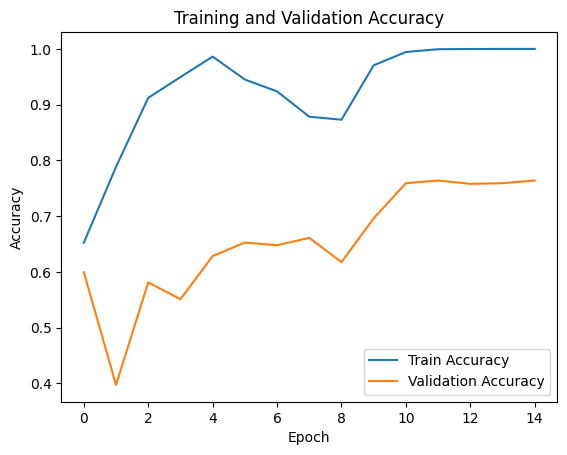

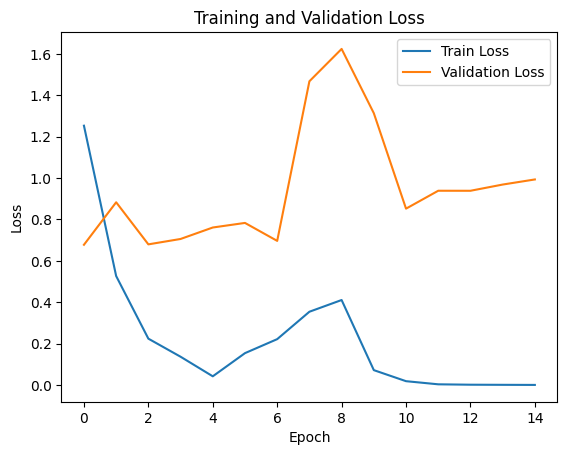

In [ ]:
# plot train and val accuracy and loss

# Plot the training and validation accuracy
plt.plot(resnet_history_2.history['accuracy'], label='Train Accuracy')
plt.plot(resnet_history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(resnet_history_2.history['loss'], label='Train Loss')
plt.plot(resnet_history_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Get predictions on the test data
y_pred_resnet_2 = resnet_model_2.predict(test_generator)
y_pred_classes_resnet_2 = np.argmax(y_pred_resnet_2, axis=1)

# Convert one-hot encoded labels back to numerical labels
y_true = test_generator.classes

# Generate classification report
report = classification_report(y_true, y_pred_classes_resnet_2)

print("Classification Report:")
print(report)

# Calculate and print accuracy
accuracy = accuracy_score(y_true, y_pred_classes_resnet_2)
print(f'Test accuracy: {accuracy * 100:.2f}%')

54/54 [==============================] - 11s 190ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.66      0.70       659
           1       0.80      0.85      0.82      1047

    accuracy                           0.78      1706
   macro avg       0.77      0.75      0.76      1706
weighted avg       0.77      0.78      0.77      1706

Test accuracy: 77.55%


54/54 [==============================] - 10s 191ms/step


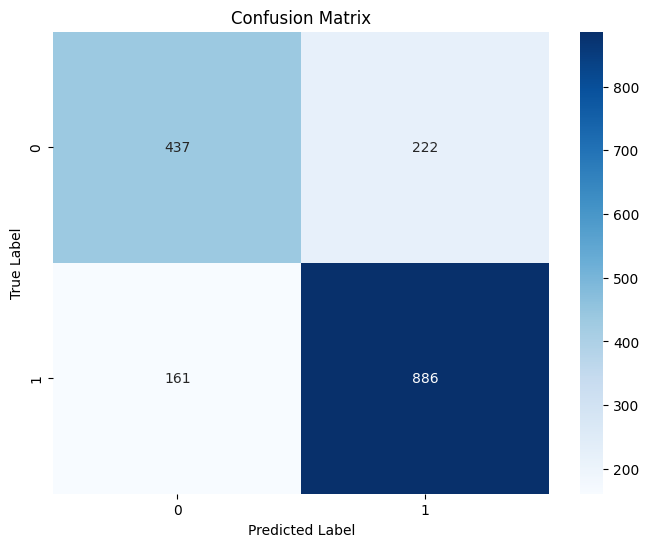

In [ ]:
#  plot confusion matrix

# Get predictions on the test data
y_pred_resnet_2 = resnet_model_2.predict(test_generator)
y_pred_classes_resnet_2 = np.argmax(y_pred_resnet_2, axis=1)

# labels
y_true = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes_resnet_2)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


54/54 [==============================] - 11s 199ms/step


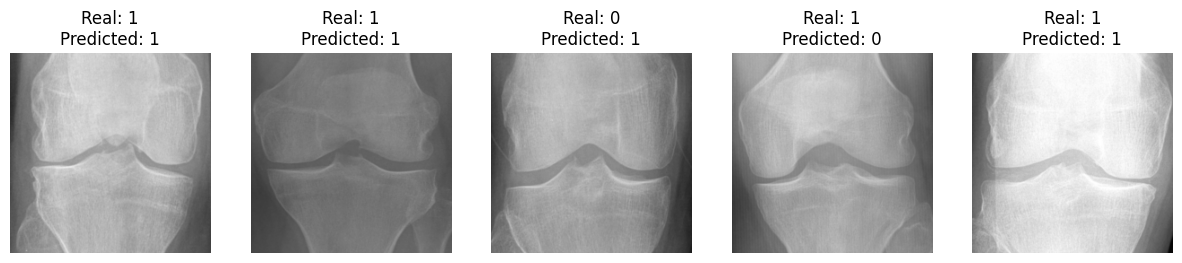

In [ ]:
# Get predictions on the test data
y_pred_resnet_2 = resnet_model_2.predict(test_generator)
y_pred_classes_resnet_2 = np.argmax(y_pred_resnet_2, axis=1)

# Retrieve true labels
y_true = test_generator.classes

# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Select a few random examples to visualize
num_examples = 5
random_indices = np.random.choice(len(test_generator.filenames), num_examples, replace=False)

# Get the images and corresponding labels from the test generator
images, _ = test_generator.next()
while len(images) < len(test_generator.filenames):
    next_images, _ = test_generator.next()
    images = np.concatenate((images, next_images))

# Plot the images and their corresponding predictions
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_examples, i + 1)

    # Clip the data to ensure it falls within the valid range
    image_data = np.clip(images[idx], 0, 1) if np.issubdtype(images[idx].dtype, np.floating) else np.clip(images[idx], 0, 255)

    plt.imshow(image_data)
    plt.title(f"Real: {class_labels[y_true[idx]]}\nPredicted: {class_labels[y_pred_classes_resnet_2[idx]]}")
    plt.axis('off')
plt.show()


# Section H (change code and train vit again for knowledge distillation)

In [5]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, ConcatDataset, Subset
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Paths to directories
train_directory = "/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/train3"
val_directory = "/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/val3"
test_directory = "/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/test3"

# Define constants
image_size = (224, 224)
batch_size = 32
num_classes = 2

# Define data transformations with data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create datasets and dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(eval(f"{x}_directory")), data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'val', 'test']}

# Combine train and validation datasets for training
combined_dataset = ConcatDataset([image_datasets['train'], image_datasets['val']])
combined_dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:

# Load pre-trained ViT model (ViT-b/16 configuration)
pretrained_model_3 = models.vit_b_16(pretrained=True)
for param in pretrained_model_3.parameters():
    param.requires_grad = False

# Modify the model for the specific number of output classes
pretrained_model_3.heads.head = nn.Linear(pretrained_model_3.heads.head.in_features, num_classes)

# Set up loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model_3.parameters(), lr=0.001, weight_decay=1e-4)

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pretrained_model_3 = pretrained_model_3.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 134MB/s]


Epoch 0/14
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train Loss: 0.5951 Acc: 0.6645
Val Loss: 0.5580 Acc: 0.6901

Epoch 1/14
----------
Train Loss: 0.5469 Acc: 0.7055
Val Loss: 0.5371 Acc: 0.7155

Epoch 2/14
----------
Train Loss: 0.5476 Acc: 0.7073
Val Loss: 0.5391 Acc: 0.7119

Epoch 3/14
----------
Train Loss: 0.5325 Acc: 0.7192
Val Loss: 0.5338 Acc: 0.7094

Epoch 4/14
----------
Train Loss: 0.5260 Acc: 0.7265
Val Loss: 0.5168 Acc: 0.7276

Epoch 5/14
----------
Train Loss: 0.5239 Acc: 0.7241
Val Loss: 0.5169 Acc: 0.7215

Epoch 6/14
----------
Train Loss: 0.5296 Acc: 0.7180
Val Loss: 0.5173 Acc: 0.7203

Epoch 7/14
----------
Train Loss: 0.5157 Acc: 0.7254
Val Loss: 0.5472 Acc: 0.7203

Epoch 8/14
----------
Train Loss: 0.5148 Acc: 0.7347
Val Loss: 0.5112 Acc: 0.7228

Epoch 9/14
----------
Train Loss: 0.5173 Acc: 0.7275
Val Loss: 0.5042 Acc: 0.7324

Epoch 10/14
----------
Train Loss: 0.5173 Acc: 0.7242
Val Loss: 0.5001 Acc: 0.7506

Epoch 11/14
----------
Train Loss: 0.5120 Acc: 0.7365
Val Loss: 0.5347 Acc: 0.7046

Epoch 12/14
----------
T

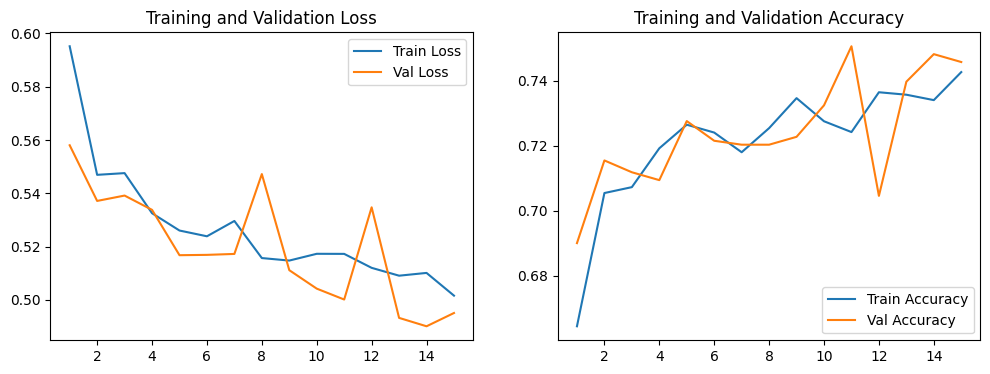

In [7]:

# Function to train the model with early stopping
def train_model(pretrained_model_3, criterion, optimizer, dataloaders, device, num_epochs=15, patience=5):
    best_model_wts = pretrained_model_3.state_dict()
    best_acc = 0.0
    epochs_no_improve = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Train with combined dataset
        pretrained_model_3.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Iterate over combined data
        for inputs, labels in combined_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            outputs = pretrained_model_3(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward + optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(combined_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(combined_dataloader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        pretrained_model_3.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        # Iterate over validation data
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward
            with torch.no_grad():
                outputs = pretrained_model_3(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders['val'].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders['val'].dataset)
        val_losses.append(epoch_loss)
        val_accuracies.append(epoch_acc.item())
        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = pretrained_model_3.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early stopping
        if epochs_no_improve >= patience:
            print("Early stopping")
            break

        print()

    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    pretrained_model_3.load_state_dict(best_model_wts)

    # Plot training & validation loss and accuracy
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.show()

    return pretrained_model_3

# Train the model
pretrained_model_3 = train_model(pretrained_model_3, criterion, optimizer, dataloaders, device, num_epochs=15)



In [8]:
# Save the model
torch.save(pretrained_model_3.state_dict(), '/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/kneeXray_vit_model_5_p3.pth')

In [12]:
# Load the model

pretrained_model_3.load_state_dict(torch.load('/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/kneeXray_vit_model_5_p3.pth'))
pretrained_model_3 = pretrained_model_3.to(device)


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.75      0.69       659
           1       0.82      0.73      0.77      1047

    accuracy                           0.74      1706
   macro avg       0.73      0.74      0.73      1706
weighted avg       0.75      0.74      0.74      1706

Test accuracy: 73.92%


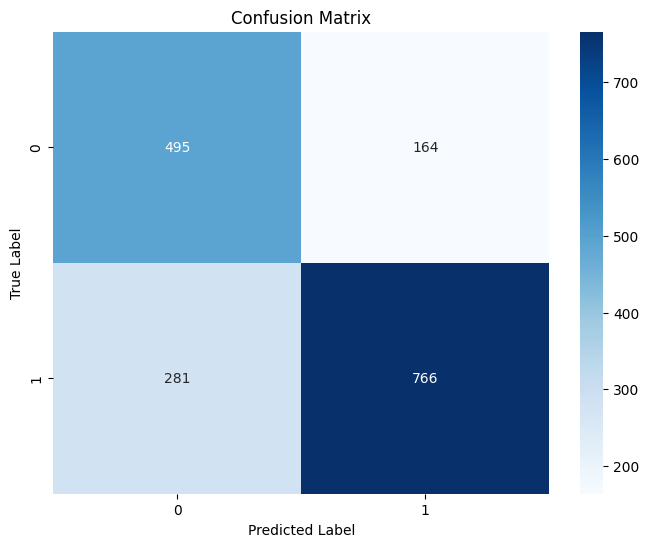

In [13]:
# Evaluate the model
pretrained_model_3.eval()
all_preds = []
all_labels = []
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2)
               for x in ['train', 'val', 'test']}

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = pretrained_model_3(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
report = classification_report(all_labels, all_preds)
print("Classification Report:")
print(report)

# Calculate and print accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test accuracy: {accuracy * 100:.2f}%')

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Knowledge Distillation ( MobileNetV2 student model and Vit_b16 teacher )

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2976: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean

Epoch 1:
Training Loss: 0.5976, Training Accuracy: 57.39%
Validation Loss: 0.6656, Validation Accuracy: 60.17%
---------------------
Epoch 2:
Training Loss: 0.5722, Training Accuracy: 59.40%
Validation Loss: 0.6691, Validation Accuracy: 60.05%
---------------------
Epoch 3:
Training Loss: 0.5502, Training Accuracy: 61.83%
Validation Loss: 0.6874, Validation Accuracy: 60.77%
---------------------
Epoch 4:
Training Loss: 0.5306, Training Accuracy: 64.01%
Validation Loss: 0.6366, Validation Accuracy: 66.95%
---------------------
Epoch 5:
Training Loss: 0.5114, Training Accuracy: 65.57%
Validation Loss: 0.6069, Validation Accuracy: 68.52%
---------------------
Epoch 6:
Training Loss: 0.4903, Training Accuracy: 67.69%
Validation Loss: 0.6014, Validation Accuracy: 66.95%
---------------------
Epoch 7:
Training Loss: 0.4728, Training Accuracy: 68.88%
Validation Loss: 0.5823, Validation Accuracy: 68.04%
---------------------
Epoch 8:
Training Loss: 0.4635, Training Accuracy: 70.04%
Validation 

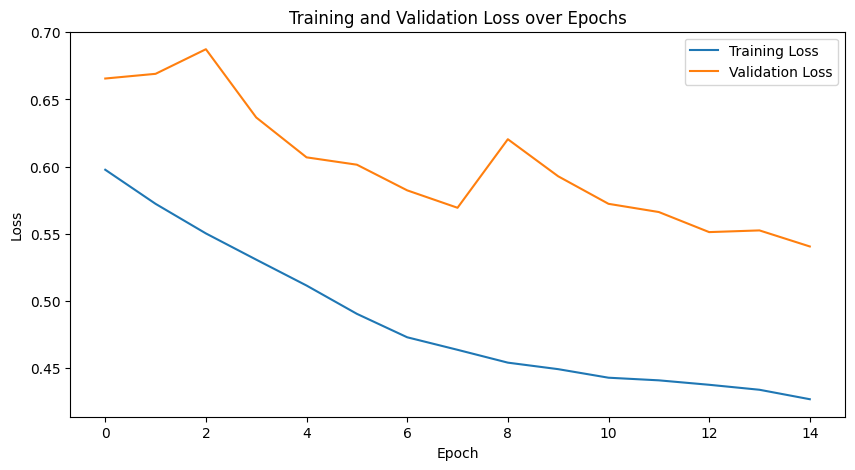

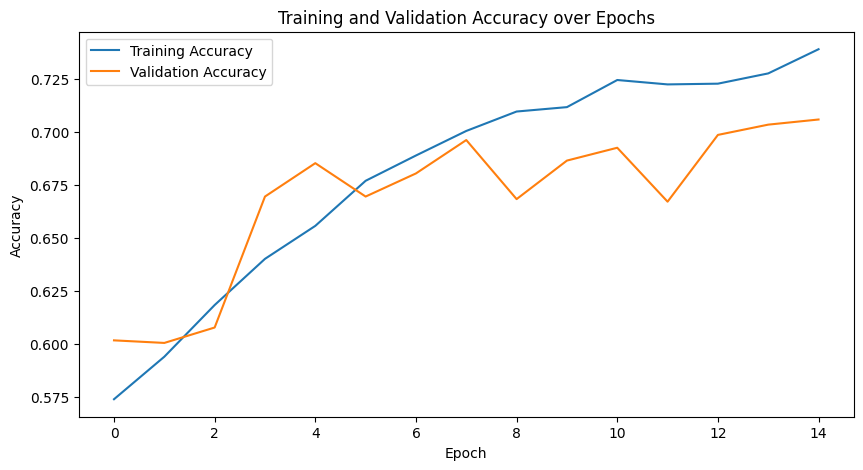

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Define MobileNetV2 student model
class MyMobileNetV2(nn.Module):
    def __init__(self, num_classes=5):
        super(MyMobileNetV2, self).__init__()
        self.model = models.mobilenet_v2(pretrained=False)
        self.model.classifier[0] = nn.Dropout(p=0.5)  # Adding Dropout
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Load the trained teacher model
teacher_model_path = '/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/kneeXray_vit_model_5_p3.pth'
teacher_model_3 = models.vit_b_16(pretrained=False)
teacher_model_3.heads.head = nn.Linear(teacher_model_3.heads.head.in_features, num_classes)
teacher_model_3.load_state_dict(torch.load(teacher_model_path))
teacher_model_3.eval()

# Initialize the student model
student_model_3 = MyMobileNetV2(num_classes=num_classes)

# Set up device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
teacher_model_3 = teacher_model_3.to(device)
student_model_3 = student_model_3.to(device)

# Knowledge Distillation training function
def train_with_distillation(student_model_3, teacher_model_3, train_loader, val_loader, criterion, optimizer, alpha, temperature, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        student_model_3.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass with teacher model
            with torch.no_grad():
                teacher_outputs = teacher_model_3(inputs)

            # Forward pass with student model
            student_outputs = student_model_3(inputs)

            # Compute distillation loss
            distillation_loss = nn.KLDivLoss()(torch.log_softmax(student_outputs / temperature, dim=1),
                                                torch.softmax(teacher_outputs / temperature, dim=1)) * (temperature ** 2)

            classification_loss = criterion(student_outputs, labels)
            loss = alpha * distillation_loss + (1 - alpha) * classification_loss

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted_train = torch.max(student_outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        student_model_3.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = student_model_3(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted_val = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}:')
        print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {100 * train_accuracy:.2f}%')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {100 * val_accuracy:.2f}%')
        print('---------------------')

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()
    plt.show()

    return student_model_3, train_losses, val_losses, train_accuracies, val_accuracies

# Set training parameters
best_alpha = 0.2
best_temperature = 3.0
criterion = nn.CrossEntropyLoss()
optimizer_student = optim.Adam(student_model_3.parameters(), lr=0.001, weight_decay=1e-4)
num_epochs = 15

# Train the student model with knowledge distillation
trained_student_model_3, train_losses, val_losses, train_accuracies, val_accuracies = train_with_distillation(
    student_model_3, teacher_model_3, dataloaders['train'], dataloaders['val'], criterion, optimizer_student, alpha=best_alpha, temperature=best_temperature, num_epochs=num_epochs
)


In [15]:
# Save the model
torch.save(trained_student_model_3.state_dict(), '/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/trained_student_model_3_p3.pth')


In [ ]:
# Load the model

trained_student_model_3.load_state_dict(torch.load('/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/trained_student_model_3_p3.pth'))
trained_student_model_3 = trained_student_model_3.to(device)


Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.84      0.70       659
           1       0.87      0.65      0.75      1047

    accuracy                           0.73      1706
   macro avg       0.74      0.75      0.73      1706
weighted avg       0.77      0.73      0.73      1706

Test accuracy: 72.68%


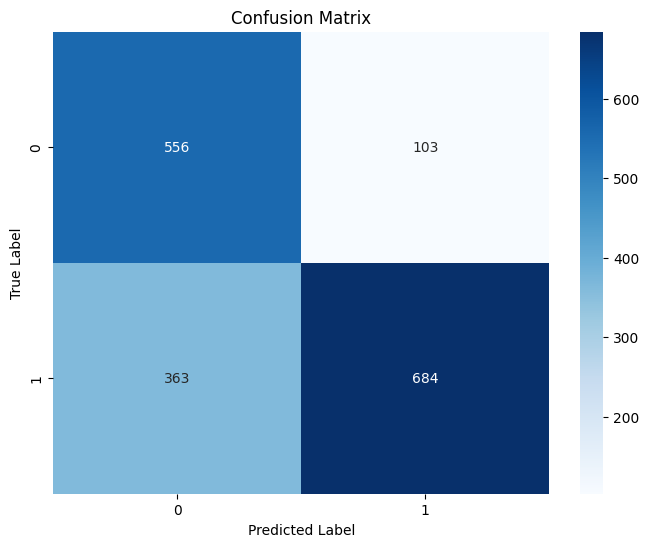

In [16]:
# Evaluate the pretrained_model
trained_student_model_3.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = trained_student_model_3(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
report = classification_report(all_labels, all_preds)
print("Classification Report:")
print(report)

# Calculate and print accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test accuracy: {accuracy * 100:.2f}%')

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Knowledge Distillation ( MobileNetV2 student model and Resnet50 teacher )

In [17]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, ConcatDataset, Subset
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Paths to directories
train_directory = "/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/train3"
val_directory = "/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/val3"
test_directory = "/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/test3"

# Define constants
image_size = (224, 224)
batch_size = 32
num_classes = 2

# Define data transformations with data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create datasets and dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(eval(f"{x}_directory")), data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'val', 'test']}

# Combine train and validation datasets for training
combined_dataset = ConcatDataset([image_datasets['train'], image_datasets['val']])
combined_dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Load pre-trained ResNet50 model
pretrained_model_4 = models.resnet50(pretrained=True)
for param in pretrained_model_4.parameters():
    param.requires_grad = True

# Modify the model for the specific number of output classes
num_ftrs = pretrained_model_4.fc.in_features
pretrained_model_4.fc = nn.Linear(num_ftrs, num_classes)

# Set up loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model_4.fc.parameters(), lr=0.001, weight_decay=1e-4)

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pretrained_model_4 = pretrained_model_4.to(device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can als

Epoch 0/14
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train Loss: 0.6522 Acc: 0.6160
Val Loss: 0.6436 Acc: 0.6356

Epoch 1/14
----------
Train Loss: 0.6187 Acc: 0.6574
Val Loss: 0.6407 Acc: 0.6356

Epoch 2/14
----------
Train Loss: 0.6310 Acc: 0.6429
Val Loss: 0.5967 Acc: 0.6877

Epoch 3/14
----------
Train Loss: 0.6129 Acc: 0.6615
Val Loss: 0.6410 Acc: 0.6525

Epoch 4/14
----------
Train Loss: 0.6212 Acc: 0.6533
Val Loss: 0.5417 Acc: 0.7215

Epoch 5/14
----------
Train Loss: 0.6017 Acc: 0.6718
Val Loss: 0.5467 Acc: 0.7167

Epoch 6/14
----------
Train Loss: 0.6024 Acc: 0.6693
Val Loss: 0.5320 Acc: 0.7252

Epoch 7/14
----------
Train Loss: 0.6056 Acc: 0.6639
Val Loss: 0.5236 Acc: 0.7252

Epoch 8/14
----------
Train Loss: 0.5976 Acc: 0.6734
Val Loss: 0.5507 Acc: 0.7300

Epoch 9/14
----------
Train Loss: 0.5972 Acc: 0.6724
Val Loss: 0.5180 Acc: 0.7458

Epoch 10/14
----------
Train Loss: 0.5916 Acc: 0.6721
Val Loss: 0.5372 Acc: 0.6949

Epoch 11/14
----------
Train Loss: 0.5895 Acc: 0.6783
Val Loss: 0.5149 Acc: 0.7458

Epoch 12/14
----------
T

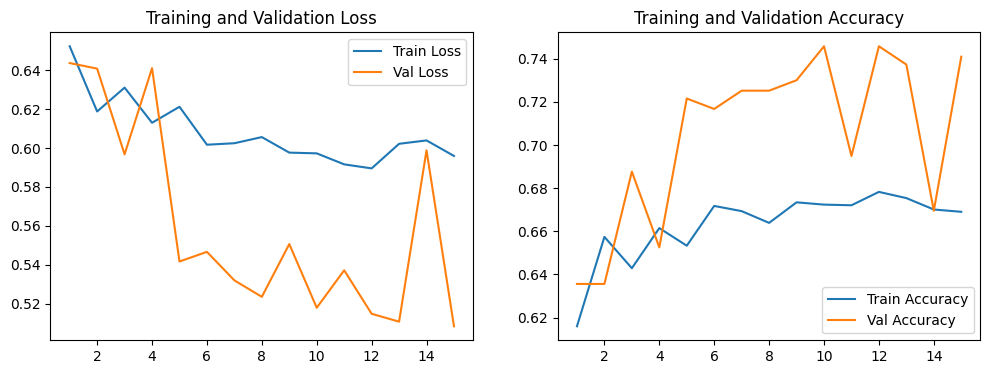

In [18]:
# Function to train the model with early stopping
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=15, patience=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    epochs_no_improve = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Train with combined dataset
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Iterate over combined data
        for inputs, labels in combined_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward + optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(combined_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(combined_dataloader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        # Iterate over validation data
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders['val'].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders['val'].dataset)
        val_losses.append(epoch_loss)
        val_accuracies.append(epoch_acc.item())
        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early stopping
        if epochs_no_improve >= patience:
            print("Early stopping")
            break

        print()

    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot training & validation loss and accuracy
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.show()

    return model

# Train the model
pretrained_model_4 = train_model(pretrained_model_4, criterion, optimizer, dataloaders, device, num_epochs=15)



In [19]:
# Save the model
torch.save(pretrained_model_4.state_dict(), '/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/kneeXray_resnet50_model_2_p3.pth')

In [ ]:
# Load the model
pretrained_model_4.load_state_dict(torch.load('/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/kneeXray_resnet50_model_2_p3.pth'))
pretrained_model_4 = pretrained_model_4.to(device)

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.46      0.54       659
           1       0.71      0.84      0.77      1047

    accuracy                           0.69      1706
   macro avg       0.68      0.65      0.65      1706
weighted avg       0.69      0.69      0.68      1706

Test accuracy: 69.34%


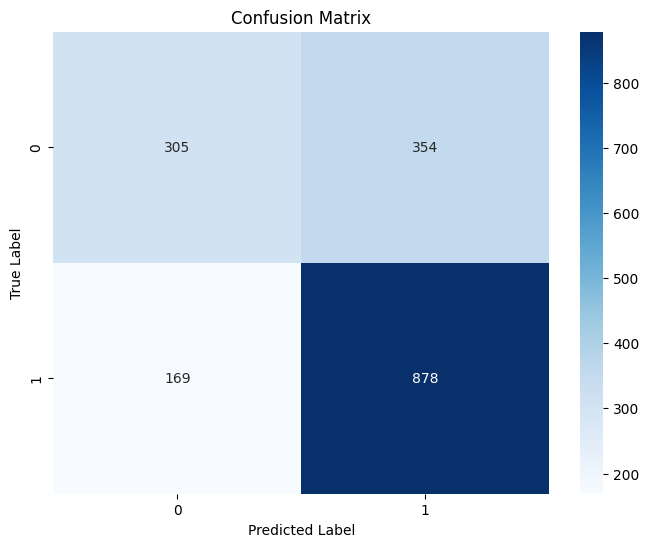

In [20]:
# Evaluate the model
pretrained_model_4.eval()
all_preds = []
all_labels = []
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2)
               for x in ['train', 'val', 'test']}

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = pretrained_model_4(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
report = classification_report(all_labels, all_preds)
print("Classification Report:")
print(report)

# Calculate and print accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test accuracy: {accuracy * 100:.2f}%')

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Define MobileNetV2 student model
class MyMobileNetV2(nn.Module):
    def __init__(self, num_classes=5):
        super(MyMobileNetV2, self).__init__()
        self.model = models.mobilenet_v2(pretrained=False)
        self.model.classifier[0] = nn.Dropout(p=0.5)  # Adding Dropout
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Load the trained teacher model
teacher_model_path = '/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/kneeXray_resnet50_model_2_p3.pth'
teacher_model_4 = models.resnet50(pretrained=False)

num_classes = 2
teacher_model_4.fc = nn.Linear(teacher_model_4.fc.in_features, num_classes)
teacher_model_4.load_state_dict(torch.load(teacher_model_path))
teacher_model_4.eval()


# Initialize the student model
student_model_4 = MyMobileNetV2(num_classes=num_classes)

# Set up device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
teacher_model_4 = teacher_model_4.to(device)
student_model_4 = student_model_4.to(device)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2976: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 1:
Training Loss: 0.5787, Training Accuracy: 57.27%
Validation Loss: 0.7720, Validation Accuracy: 59.93%
---------------------
Epoch 2:
Training Loss: 0.5559, Training Accuracy: 59.28%
Validation Loss: 0.6594, Validation Accuracy: 59.32%
---------------------
Epoch 3:
Training Loss: 0.5279, Training Accuracy: 62.79%
Validation Loss: 0.6293, Validation Accuracy: 62.95%
---------------------
Epoch 4:
Training Loss: 0.5132, Training Accuracy: 64.56%
Validation Loss: 0.6263, Validation Accuracy: 64.53%
---------------------
Epoch 5:
Training Loss: 0.5011, Training Accuracy: 66.33%
Validation Loss: 0.6494, Validation Accuracy: 62.59%
---------------------
Epoch 6:
Training Loss: 0.4815, Training Accuracy: 67.33%
Validation Loss: 0.6108, Validation Accuracy: 64.53%
---------------------
Epoch 7:
Training Loss: 0.4759, Training Accuracy: 68.21%
Validation Loss: 0.5814, Validation Accuracy: 67.31%
---------------------
Epoch 8:
Training Loss: 0.4656, Training Accuracy: 68.90%
Validation 

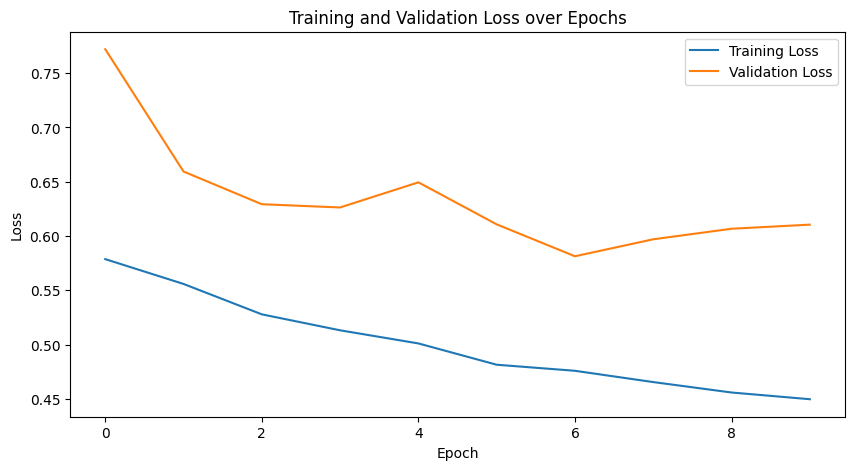

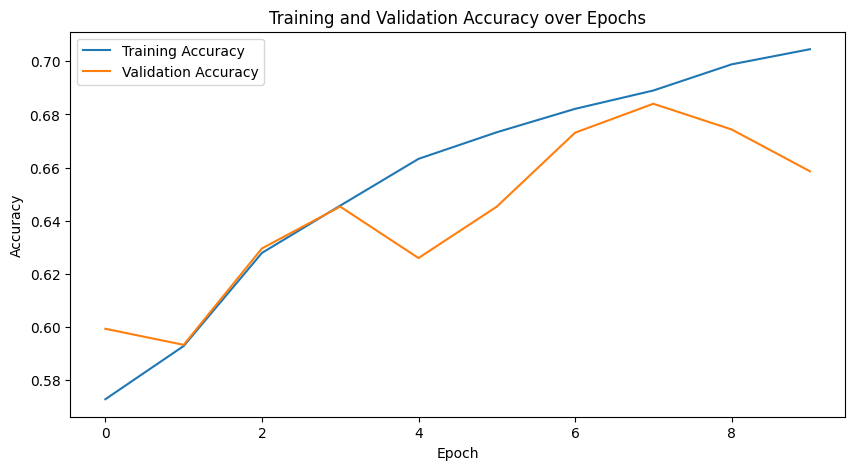

In [23]:

# Knowledge Distillation training function
def train_with_distillation(student_model_4, teacher_model_4, train_loader, val_loader, criterion, optimizer, alpha, temperature, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        student_model_4.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass with teacher model
            with torch.no_grad():
                teacher_outputs = teacher_model_4(inputs)

            # Forward pass with student model
            student_outputs = student_model_4(inputs)

            # Compute distillation loss
            distillation_loss = nn.KLDivLoss()(torch.log_softmax(student_outputs / temperature, dim=1),
                                                torch.softmax(teacher_outputs / temperature, dim=1)) * (temperature ** 2)

            classification_loss = criterion(student_outputs, labels)
            loss = alpha * distillation_loss + (1 - alpha) * classification_loss

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted_train = torch.max(student_outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        student_model_4.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = student_model_4(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted_val = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}:')
        print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {100 * train_accuracy:.2f}%')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {100 * val_accuracy:.2f}%')
        print('---------------------')

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()
    plt.show()

    return student_model_4, train_losses, val_losses, train_accuracies, val_accuracies

# Set training parameters
best_alpha = 0.2
best_temperature = 3.0
criterion = nn.CrossEntropyLoss()
optimizer_student = optim.Adam(student_model_4.parameters(), lr=0.001, weight_decay=1e-4)
num_epochs = 10

# Train the student model with knowledge distillation
trained_student_model_4, train_losses, val_losses, train_accuracies, val_accuracies = train_with_distillation(
    student_model_4, teacher_model_4, dataloaders['train'], dataloaders['val'], criterion, optimizer_student, alpha=best_alpha, temperature=best_temperature, num_epochs=num_epochs
)


In [24]:
# Save the model
torch.save(trained_student_model_4.state_dict(), '/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/trained_student_model_4_p3.pth')


In [ ]:
# Load the model

student_model_4.load_state_dict(torch.load('/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/trained_student_model_4_p3.pth'))
student_model_4 = student_model_4.to(device)


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.27      0.39       659
           1       0.67      0.94      0.78      1047

    accuracy                           0.68      1706
   macro avg       0.70      0.60      0.59      1706
weighted avg       0.70      0.68      0.63      1706

Test accuracy: 68.00%


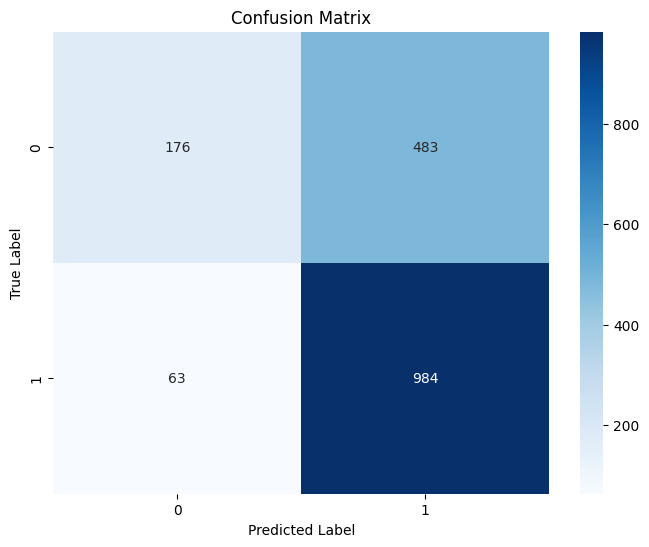

In [25]:
# Evaluate the pretrained_model
trained_student_model_4.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = trained_student_model_4(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
report = classification_report(all_labels, all_preds)
print("Classification Report:")
print(report)

# Calculate and print accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test accuracy: {accuracy * 100:.2f}%')

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# data auggmentation

In [26]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, ConcatDataset, Subset
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Paths to directories
train_directory = "/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/train3"
val_directory = "/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/val3"
test_directory = "/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/test3"

# Define constants
image_size = (224, 224)
batch_size = 32
num_classes = 2

# Define data transformations with more data augmentation techniques
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create datasets and dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(eval(f"{x}_directory")), data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'val', 'test']}

# Combine train and validation datasets for training
combined_dataset = ConcatDataset([image_datasets['train'], image_datasets['val']])
combined_dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Load pre-trained ViT model (ViT-b/16 configuration)
pretrained_model_4 = models.vit_b_16(pretrained=True)
for param in pretrained_model_4.parameters():
    param.requires_grad = False

# Modify the model for the specific number of output classes
pretrained_model_4.heads.head = nn.Linear(pretrained_model_4.heads.head.in_features, num_classes)

# Set up loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model_4.parameters(), lr=0.001, weight_decay=1e-4)

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pretrained_model_4 = pretrained_model_4.to(device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can als

Epoch 0/14
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train Loss: 0.5937 Acc: 0.6637
Val Loss: 0.5577 Acc: 0.7022

Epoch 1/14
----------
Train Loss: 0.5547 Acc: 0.6981
Val Loss: 0.5516 Acc: 0.7046

Epoch 2/14
----------
Train Loss: 0.5547 Acc: 0.7052
Val Loss: 0.5358 Acc: 0.7094

Epoch 3/14
----------
Train Loss: 0.5380 Acc: 0.7150
Val Loss: 0.5452 Acc: 0.6925

Epoch 4/14
----------
Train Loss: 0.5330 Acc: 0.7118
Val Loss: 0.5288 Acc: 0.7228

Epoch 5/14
----------
Train Loss: 0.5286 Acc: 0.7165
Val Loss: 0.5176 Acc: 0.7421

Epoch 6/14
----------
Train Loss: 0.5330 Acc: 0.7151
Val Loss: 0.5252 Acc: 0.7131

Epoch 7/14
----------
Train Loss: 0.5227 Acc: 0.7282
Val Loss: 0.5354 Acc: 0.7240

Epoch 8/14
----------
Train Loss: 0.5154 Acc: 0.7306
Val Loss: 0.5104 Acc: 0.7312

Epoch 9/14
----------
Train Loss: 0.5223 Acc: 0.7289
Val Loss: 0.5037 Acc: 0.7288

Epoch 10/14
----------
Train Loss: 0.5252 Acc: 0.7269
Val Loss: 0.5067 Acc: 0.7264
Early stopping
Best val Acc: 0.7421


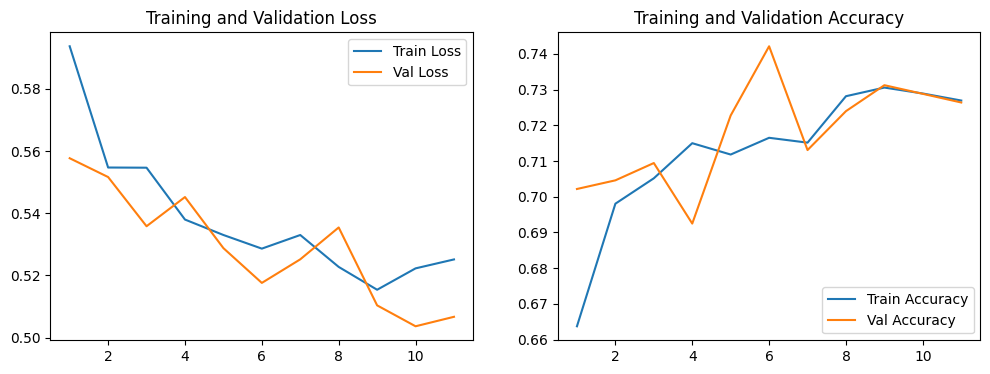

In [27]:

# Function to train the model with early stopping
def train_model(pretrained_model_4, criterion, optimizer, dataloaders, device, num_epochs=15, patience=5):
    best_model_wts = pretrained_model_4.state_dict()
    best_acc = 0.0
    epochs_no_improve = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Train with combined dataset
        pretrained_model_4.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Iterate over combined data
        for inputs, labels in combined_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            outputs = pretrained_model_4(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward + optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(combined_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(combined_dataloader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        pretrained_model_4.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        # Iterate over validation data
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward
            with torch.no_grad():
                outputs = pretrained_model_4(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders['val'].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders['val'].dataset)
        val_losses.append(epoch_loss)
        val_accuracies.append(epoch_acc.item())
        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = pretrained_model_4.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early stopping
        if epochs_no_improve >= patience:
            print("Early stopping")
            break

        print()

    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    pretrained_model_4.load_state_dict(best_model_wts)

    # Plot training & validation loss and accuracy
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.show()

    return pretrained_model_4

# Train the model
pretrained_model_4 = train_model(pretrained_model_4, criterion, optimizer, dataloaders, device, num_epochs=15)

# Save the model
torch.save(pretrained_model_4.state_dict(), '/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/kneeXray_vit_model_6_p3.pth')



In [29]:
# Load the model
pretrained_model_4.load_state_dict(torch.load('/content/drive/MyDrive/Colab_Notebooks/cog_rob/KneeXray/kneeXray_vit_model_6_p3.pth'))
pretrained_model_4 = pretrained_model_4.to(device)

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.55      0.61       659
           1       0.75      0.84      0.79      1047

    accuracy                           0.73      1706
   macro avg       0.71      0.69      0.70      1706
weighted avg       0.72      0.73      0.72      1706

Test accuracy: 72.57%


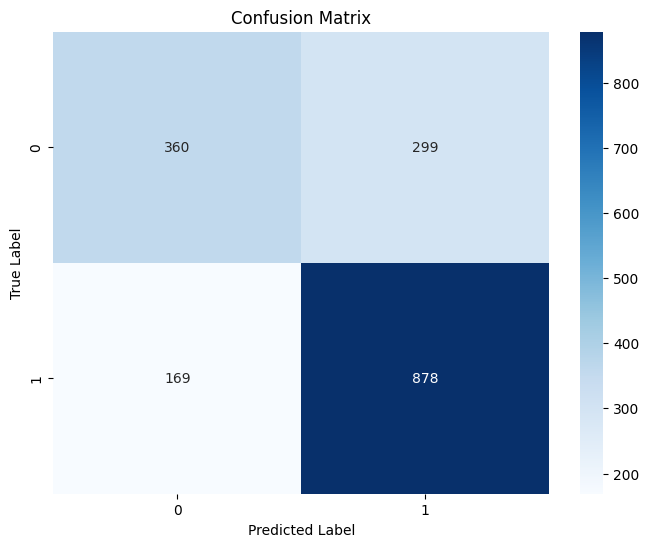

In [28]:
# Evaluate the model
pretrained_model_4.eval()
all_preds = []
all_labels = []
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2)
               for x in ['train', 'val', 'test']}

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = pretrained_model_4(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
report = classification_report(all_labels, all_preds)
print("Classification Report:")
print(report)

# Calculate and print accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test accuracy: {accuracy * 100:.2f}%')

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
